In [1]:
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.under_sampling import RandomUnderSampler, TomekLinks
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
import math

pd.options.display.max_columns = 999

#importing all of the packages that we need. Includes numpy, pandas, ml models, etc

In [2]:
#importing the dataset
df = pd.read_csv(r'water_potability.csv')

In [3]:
#looking at the head and end to see what it looks like
df.head(-1)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1


In [4]:
df.isnull().sum()
#Looking at how many null values are in dataset
#There are 3 columns that have missing values

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [5]:
#Taking note of full size of dataset
df.size

32760

In [6]:
#making sure median function works when we use it later
df['ph'].median()

7.036752103833548

In [7]:
#looking at ph values
df['ph']

0            NaN
1       3.716080
2       8.099124
3       8.316766
4       9.092223
          ...   
3271    4.668102
3272    7.808856
3273    9.419510
3274    5.126763
3275    7.874671
Name: ph, Length: 3276, dtype: float64

In [8]:
#removing every row that has 2 or more null values, since that is too much data lost
df.size

null_counts = df.isnull().sum(axis = 1)

for i in range(len(null_counts)):
    if null_counts[i] > 1:
        df = df.drop(i)
        
df.size

31160

In [9]:
#impute the rest of the null values using the median for the column
def impute_median_ph(value):
    if(math.isnan(value)):
        return df['ph'].median()
    else:
        return value
    
def impute_median_Sulfate(value):
    if(math.isnan(value)):
        return df['Sulfate'].median()
    else:
        return value
    
def impute_mean_Sulfate(value):
    if(math.isnan(value)):
        return df['Sulfate'].mean()
    else:
        return value
    
def impute_median_T(value):
    if(math.isnan(value)):
        return df['Trihalomethanes'].median()
    else:
        return value
    
#we are creating two lists here to use in a later visualization
#One is the sulfate column w/ median imputation, the other w/ mean imputation
Sulfate_mean = df['Sulfate'].apply(impute_mean_Sulfate)
Sulfate_median = df['Sulfate'].apply(impute_median_Sulfate)

#the actual imputation    
df['ph'] = df['ph'].apply(impute_median_ph)
df['Sulfate'] = df['Sulfate'].apply(impute_median_Sulfate)
df['Trihalomethanes'] = df['Trihalomethanes'].apply(impute_median_T)

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.037422,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073455,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073455,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [10]:
#We can skip the encoding step since this dataset has no categorical features

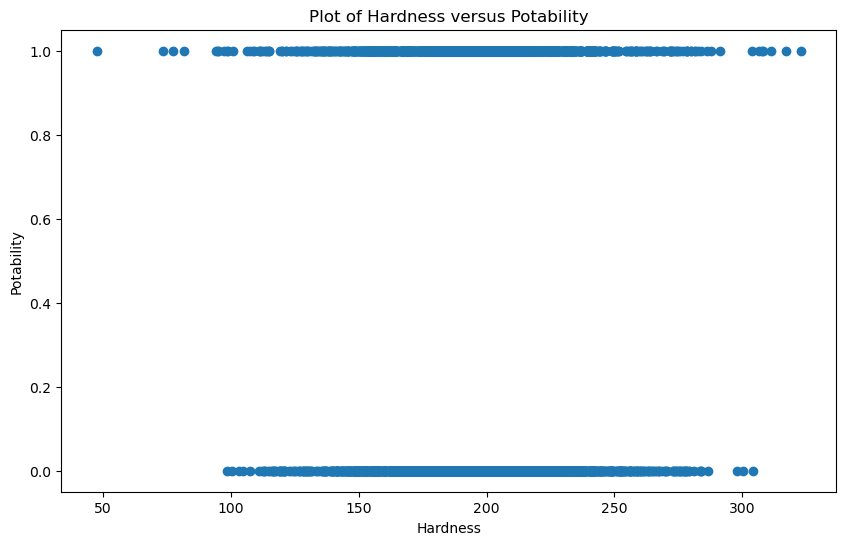

In [11]:
#Below are a few scatterplots showing one of the columns on the x axis and the potability on the y axis
#The goal is to see how certain values on the x axis will affect the potability of the water

plt.figure(figsize=(10,6))
plt.scatter(df['Hardness'], df['Potability'])
plt.title('Plot of Hardness versus Potability')
plt.xlabel('Hardness')
plt.ylabel('Potability')
plt.show()

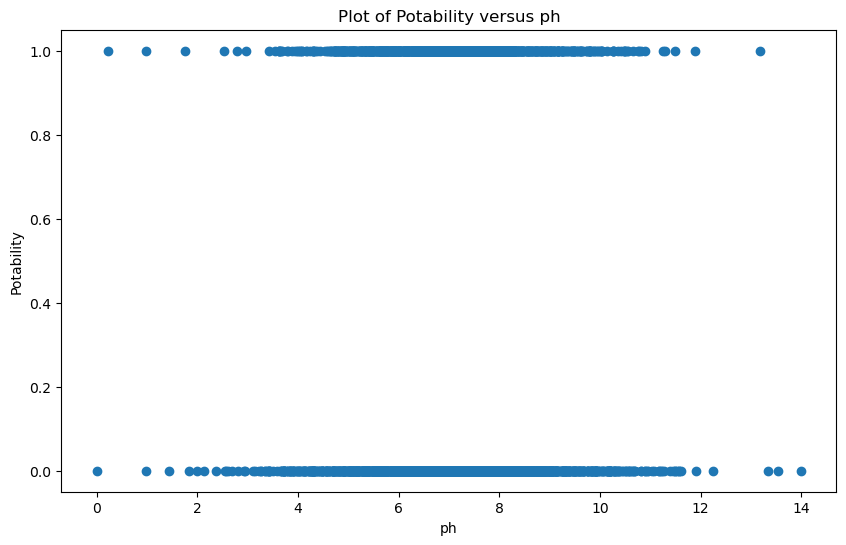

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(df['ph'], df['Potability'])
plt.title('Plot of Potability versus ph')
plt.xlabel('ph')
plt.ylabel('Potability')
plt.show()

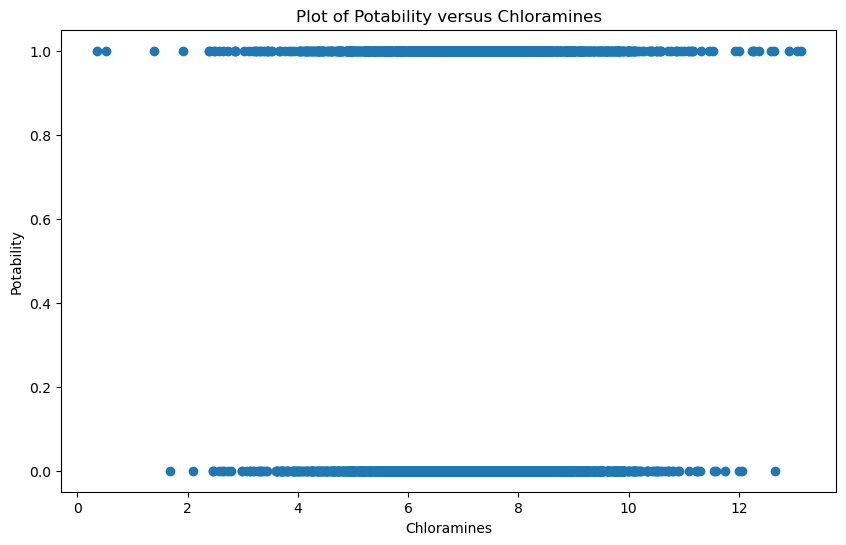

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(df['Chloramines'], df['Potability'])
plt.title('Plot of Potability versus Chloramines')
plt.xlabel('Chloramines')
plt.ylabel('Potability')
plt.show()

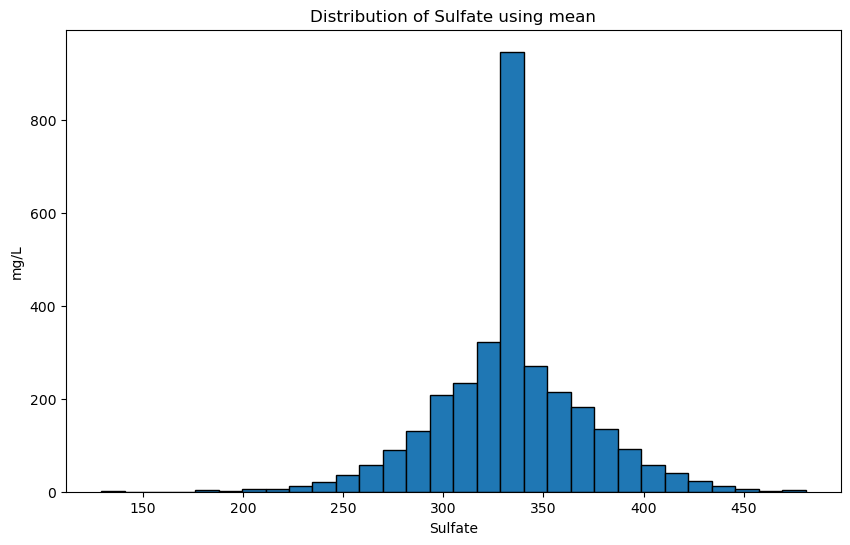

In [16]:
plt.figure(figsize=(10,6))
plt.hist(Sulfate_mean, bins=30, edgecolor='black')
plt.title('Distribution of Sulfate using mean')
plt.xlabel('Sulfate')
plt.ylabel('mg/L')
plt.show()

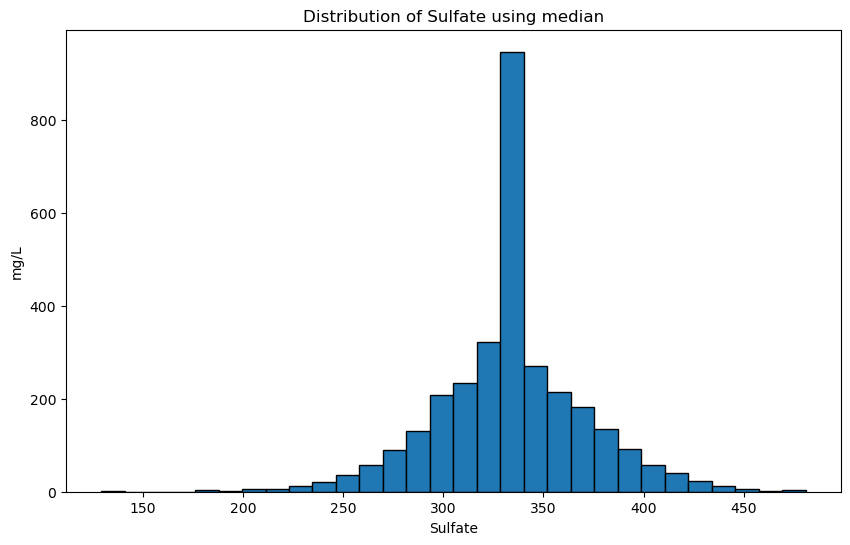

In [18]:
plt.figure(figsize=(10,6))
plt.hist(Sulfate_median, bins=30, edgecolor='black')
plt.title('Distribution of Sulfate using median')
plt.xlabel('Sulfate')
plt.ylabel('mg/L')
plt.show()

In [17]:
#Splitting the dataset
X = df.drop(["Potability"], axis=1)
y = df["Potability"]

In [15]:
#Making the test size %20 of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [16]:
columns_to_scale = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
columns_no_scale = [col for col in X_train.columns if col not in columns_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('no_scaler', 'passthrough', columns_no_scale)
    ]
)

In [17]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train

array([[-2.0356997 ,  3.27876538,  1.28060654, ..., -0.27247949,
         0.33911534,  1.3634611 ],
       [-0.69277511, -1.4045749 , -0.96744588, ...,  1.69281977,
        -1.43386556,  1.22191821],
       [-0.45090404, -0.41870229, -0.47976329, ...,  0.91868075,
        -0.15587768,  0.78267921],
       ...,
       [-0.24451579, -0.10417647, -0.69099967, ...,  1.09151873,
         1.16052172,  1.33126336],
       [-0.38473011,  1.3380376 ,  0.8585689 , ..., -0.22497495,
         1.65748093,  0.68419356],
       [-0.7544934 , -1.82630952,  0.69491173, ...,  0.32780729,
         0.14947646,  1.03494994]])

In [18]:
X_train = pd.DataFrame(X_train, columns=columns_to_scale + columns_no_scale)
X_test = pd.DataFrame(X_test, columns=columns_to_scale + columns_no_scale)

X_train

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-2.035700,3.278765,1.280607,-1.695879,-0.023316,0.846089,-0.272479,0.339115,1.363461
1,-0.692775,-1.404575,-0.967446,-0.411638,1.872256,-0.417541,1.692820,-1.433866,1.221918
2,-0.450904,-0.418702,-0.479763,0.224905,-0.039514,-0.336203,0.918681,-0.155878,0.782679
3,-1.156762,-0.084418,1.117554,0.702421,-0.184540,0.068404,-0.774837,-0.670273,-0.164620
4,0.418268,-0.231630,-0.754087,-1.302289,-0.308184,1.201635,0.547385,-0.578705,1.198395
...,...,...,...,...,...,...,...,...,...
2487,0.549142,0.648955,0.176014,0.244046,-1.512047,1.512273,-1.218225,-0.086680,-1.068364
2488,-1.550094,-1.422830,-0.325577,0.524606,1.119700,-0.315518,-0.972234,0.167585,0.792248
2489,-0.244516,-0.104176,-0.691000,-0.466706,-0.537378,-1.357135,1.091519,1.160522,1.331263
2490,-0.384730,1.338038,0.858569,-0.209871,0.215612,-1.988576,-0.224975,1.657481,0.684194


In [19]:
#Random Forest Model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
y_pred = rf_classifier.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.70
Precision: 0.70
Recall: 0.42
F1 Score: 0.52


In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

best_rf_classifier = grid_search.best_estimator_

y_pred = best_rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.70
Precision: 0.72
Recall: 0.40
F1 Score: 0.51
